[1] 모듈 로딩 및 데이터 준비
- scikit - learn에서 데이터 다운 및 확인

In [248]:
# 모듈 로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn                         # LinearRegression 기능의 클래스 Linear
import torch.nn.functional as F               # 손실함수
import torch.optim as optim                   # 경사하강법 기반의 최적화 관련 모듈

In [249]:
### ===> 데이터 준비
fashion_db = 'fashion-mnist'

# fashion_data = fetch_openml(name = fashion_db, parser = 'auto', as_frame = False)   
fashion_data = fetch_openml(name = fashion_db, parser = 'auto')   
#as_frame이 True이면 dataframe으로 들고 들어옴, false이면 numpy로 들어옴

In [250]:
### ===> 데이터 확인
feature = fashion_data['data']
target = fashion_data['target']

In [251]:
# 피처와 타겟 개수 확인
print(f"feature => {feature.shape}, {feature.ndim}D")
print(f"target => {target.shape}, {target.ndim}D")

feature => (70000, 784), 2D
target => (70000,), 1D


In [252]:
# 분류 확인
print(f"feature => {fashion_data['feature_names']}")
print(f"feature => {fashion_data['target_names']}")
print(f"category => {fashion_data['categories']}")         # 판다스면 None 이지만   넘파이면 카테고리가 들어옴
print(f"category => {target.unique()}")

feature => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel9

[2] 데이터 가공 및 전처리 
- 결측치 / 중복값 / 이상치 => 이 데이터에서는 현재 없음
- 다중 분류 => 2진 분류 변환 : target 변환
- 이미지 크기 표준화 --> 여기서는 이미지 동일 크기 및 색상 채널 : 동일 크기(28*28)와 채널(흑백 1) (만약에 내가 들고온 사진 파일들은 다 다르니까)
- 정규화 => 피처 정규화 / 타겟 정규화

In [253]:
### ===> [2-1] 다중 분류 => 2진 분류 변환 : target 변환
target = target == '0'
target.unique()

array([False,  True])

In [254]:
### ===> [2-2] 정규화 => 피처 : 784개 색상값 즉, 0~ 255 번위 값
norm_feature = feature/255.
# 정수 / 실수 => 실수로 형변환

In [255]:
norm_feature.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
### ===> [2-2] 정규화 => 타겟 : One-Hot 인코딩으로 변환
pd.get_dummies(target)

,False,True
0,True,False
1,False,True
2,False,True
3,True,False
4,False,True
...,...,...
69995,True,False
69996,True,False
69997,True,False
69998,True,False


In [257]:
from sklearn.preprocessing import OneHotEncoder
targetDF=target.to_frame()          # to_frame() : Convert Series to DataFrame.
print(targetDF.shape)

# 2차원으로 바꿔서 넘겨주겠다.

(70000, 1)


In [258]:
# sparse_ouput = False   : ndarray 타입으로 반환
ohEncoder = OneHotEncoder(sparse_output= False)       # sparse를 False를 지정하면 처음부터 풀어서 받겠다는 솔의  (메모리 문제 때문에 압축해서 줌)
ohEncoder.fit(targetDF)
ohEncoder.categories_

# get_dummies vs onehotencoding vs labelencoding : https://hye-z.tistory.com/16

[array([False,  True])]

In [259]:
norm_target = ohEncoder.transform(targetDF)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

In [260]:
norm_target[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

- 데이터 => 숫자 변환
- 글자 => 정수 변환 => 원핫인코딩 => 밀집행렬 [입베딩]

- 원핫인코딩 vs 라벨인코딩 vs ordinalencoder        => 노션에 적어놈

[3] 학습 준비 <hr>
- 텐서화
- 데이터셋 준비 : 훈련용, 테스트용
- 학습 방법 : 지도학습 - 이진분류 => Linear 클래스 + sigmoid 함수
- 최적화 방법 : 경사하강법기반의 방법 => Adam, SDG, ...
- 손실 함수 : 이진 분류 손실 계산 함수 => binary_cross_entropy

In [261]:
### ===> 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000

train = norm_feature.iloc[0:limit]
test = norm_feature.iloc[limit:]

train_y = target[:limit]
test_y = target[limit:]

In [262]:
print(f"train : {train.shape}, {train.ndim}D  {train_y.shape}, {train_y.ndim}D")
print(f"test : {test.shape}, {test.ndim}D  {test_y.shape}, {test_y.ndim}D")

train : (60000, 784), 2D  (60000,), 1D
test : (10000, 784), 2D  (10000,), 1D


In [263]:
test_y

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998    False
69999    False
Name: class, Length: 10000, dtype: bool

In [264]:
### ===> 텐서로 변환
X_train = torch.FloatTensor(train.values)
X_test = torch.FloatTensor(test.values)

y_train = torch.FloatTensor(train_y.values).unsqueeze(dim=1)
y_test = torch.FloatTensor(test_y.values).unsqueeze(dim=1)

In [265]:
print(f"train : {X_train.shape}, {X_train.ndim}D  {train_y.shape}, {train_y.ndim}D")
print(f"test : {X_test.shape}, {X_test.ndim}D  {test_y.shape}, {test_y.ndim}D")

train : torch.Size([60000, 784]), 2D  (60000,), 1D
test : torch.Size([10000, 784]), 2D  (10000,), 1D


In [266]:
### 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1]
model = nn.Linear(in_, out_)
model

Linear(in_features=784, out_features=1, bias=True)

In [267]:
### 최적화 인스턴스 생성 => 모델에서 사용하는 W, b 변수들 전달
optimizer = optim.Adam(model.parameters())    # [w1, w2, ..., w784, 1]

In [268]:
### 학습 횟수 => 샘플 처음부터 끝까지 읽는 것 기준으로 횟수 지정
EPOCHS = 150

[4] 학습 <hr>
- 반복횟수만큼 학습 진행

In [269]:
loss_list = []
loss_accuracy = [[], []]
for ep in range(EPOCHS):
    # 학습
    pre_y = model(X_train)
    #print(f"예측값 : {pre_y}")
    
    # 분류값 변화
    pre_y2 = F.sigmoid(pre_y)
    #print(f"분류값 : {pre_y2}")
        
    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(pre_y2, y_train)
    loss_list.append(loss.item())
    loss_accuracy[0].append(loss.item())
    print(f'[{ep}] Loss => {loss}')                
    
    # W, b 업데이트
    optimizer.zero_grad()
    loss.backward()  # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step()    # 새로운 값으로 W, b 업데이트
    
    # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
    train_accuracy = ((y_train == (pre_y2 >= 0.5)).sum() )/ y_train.shape[0]
    loss_accuracy[1].append(train_accuracy)

[0] Loss => 0.6633749604225159
[1] Loss => 0.5918515920639038
[2] Loss => 0.5348621010780334
[3] Loss => 0.4909508526325226
[4] Loss => 0.4581066370010376
[5] Loss => 0.4341408610343933
[6] Loss => 0.41697242856025696
[7] Loss => 0.40479180216789246
[8] Loss => 0.39612337946891785
[9] Loss => 0.3898182213306427
[10] Loss => 0.3850127160549164
[11] Loss => 0.381075382232666
[12] Loss => 0.3775559365749359
[13] Loss => 0.37414252758026123
[14] Loss => 0.37062689661979675
[15] Loss => 0.36687812209129333
[16] Loss => 0.36282244324684143
[17] Loss => 0.3584282696247101
[18] Loss => 0.3536956310272217
[19] Loss => 0.34864747524261475
[20] Loss => 0.3433237671852112
[21] Loss => 0.33777695894241333
[22] Loss => 0.3320680856704712
[23] Loss => 0.3262636959552765
[24] Loss => 0.32043352723121643
[25] Loss => 0.3146476745605469
[26] Loss => 0.30897432565689087
[27] Loss => 0.30347704887390137
[28] Loss => 0.2982122600078583
[29] Loss => 0.29322654008865356
[30] Loss => 0.2885541021823883
[31] L

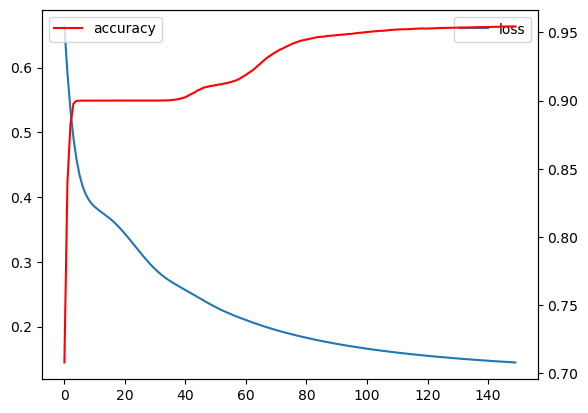

In [270]:
# 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuracy[0], label = 'loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(loss_accuracy[1], label = 'accuracy', color = 'red')
ax2.legend()
plt.xlabel('Epochs')
plt.show()